## Bibliotecas

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl as opx
import scipy.optimize as scy


## Importando Arquivo de dados


In [138]:
df=pd.read_excel(r'E:\eduro\Documents\Graduação ITA\Iniciação científica\Dados-impedancia.xlsx')

In [139]:
#importando excel
wb=opx.load_workbook('Dados-impedancia.xlsx')
#abrindo página de localização da tabela
ws=wb['arg03']

In [140]:
def create_df_from_excel(ws,nome_da_tabela):
    mapping = {}

    for entry, data_boundary in ws.tables.items():
        #parse the data within the ref boundary
        data = ws[data_boundary]
        #extract the data 
        #the inner list comprehension gets the values for each cell in the table
        content = [[cell.value for cell in ent] 
                for ent in data
            ]
        header = content[0]
        #the contents ... excluding the header
        rest = content[1:]
        #create dataframe with the column names
        #and pair table name with dataframe
        df = pd.DataFrame(rest, columns = header)
        mapping[entry] = df
    return mapping[nome_da_tabela]


In [141]:
df=create_df_from_excel(ws,'graf_03')
df.dropna(how='all',inplace=True)

In [142]:
df.rename(columns={'Column1':'Frequency','Column2':'Impedance','Column3':'Phase'},inplace=True)
df.drop(columns={'Column4','Column5'},inplace=True)

## Criação de Colunas


In [143]:
df['Phase_Rad']=np.radians(df['Phase'])
df.rename(columns={'Phase':'Phase_degree'},inplace=True)

In [144]:
df['Omega']=2*np.pi*df['Frequency']

In [145]:
df['Impedance_Real']=df['Impedance']*np.cos(df['Phase_Rad'])
df['Impedance_Imaginary']=np.abs(df['Impedance']*np.sin(df['Phase_Rad']))

Text(0, 0.5, 'Impedância Imaginária')

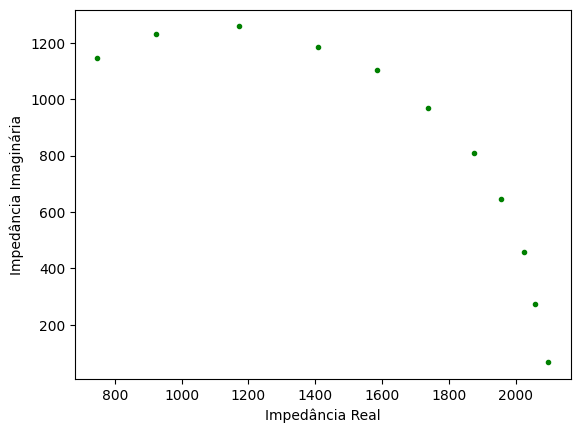

In [146]:
fig, axs = plt.subplots(1, 1)
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'g.')
plt.xlabel('Impedância Real')
plt.ylabel('Impedância Imaginária')

## Funções para calcular a melhor curva

In [147]:
def func_real(w,R,t,a):
    f=R*(1+np.cos((1-a)*np.pi/2)*(w*t)**(1-a))/(1+ (w*t)**(2-2*a) +2*np.cos((1-a)*np.pi/2)*(w*t)**(1-a))
    return f
def func_im(w,R,t,a):
    f=np.abs(-1*R*(np.sin((1-a)*np.pi/2)*(w*t)**(1-a))/(1+ (w*t)**(2-2*a) +2*np.cos((1-a)*np.pi/2)*(w*t)**(1-a)))
    return f

## Tentativa de dar um guess nos parâmetros

In [148]:
def plotar(R,t,a,start,stop,len):
    xx=np.linspace(start,stop,num=len)
    z_im=func_im(xx,R,t,a)
    z_real=func_real(xx,R,t,a)
    plt.plot(abs(z_real),abs(z_im),'*')
    #axs.axis('equal')
    axs.grid()

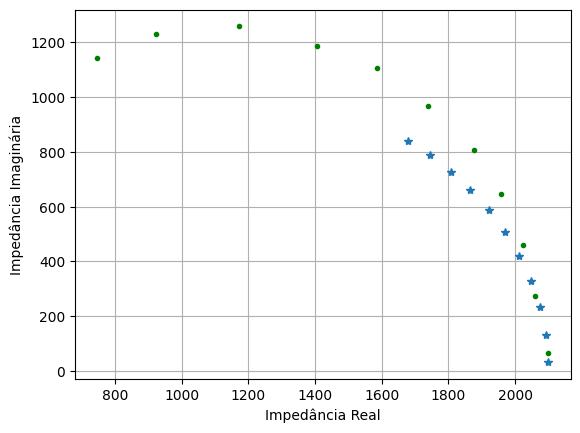

In [149]:
fig, axs = plt.subplots(1, 1)
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'g.')
plt.xlabel('Impedância Real')
plt.ylabel('Impedância Imaginária')
plotar(2100,1/2000000,0.000001,30000,1000000,len=11)
plt.show()

## Utilização do curve_fit para acertar os parâmetros

In [150]:
popt_real, pcov_real = scy.curve_fit(func_real, df.Omega, df.Impedance_Real,bounds=(0,[10**6,10**2,1]),maxfev=100000)
perr_real = np.sqrt(np.diag(pcov_real))

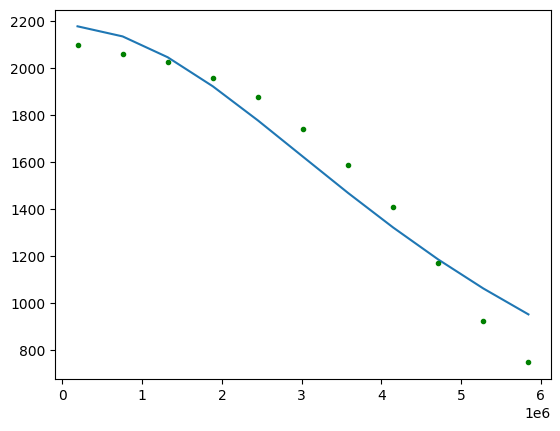

In [151]:
plt.plot(df.Omega,func_real(df.Omega,*popt_real))
plt.plot(df.Omega,df['Impedance_Real'],'g.')

In [152]:
popt_im, pcov_im=scy.curve_fit(func_im, df.Omega, df.Impedance_Imaginary,p0=popt_real,maxfev=100000,bounds=(0,[10**6,10**2,1]))
perr_im = np.sqrt(np.diag(pcov_im))

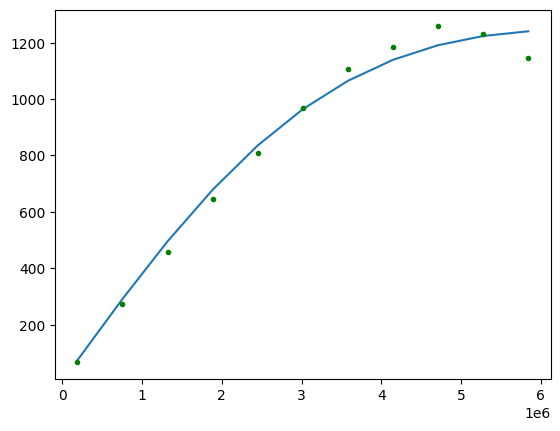

In [153]:
plt.plot(df.Omega,func_im(df.Omega,*popt_im))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

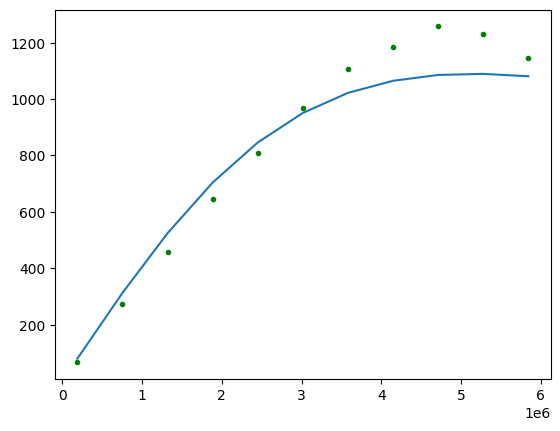

In [154]:
plt.plot(df['Omega'],np.abs(func_im(df['Omega'],*popt_real)))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

## Loop para tentar achar a melhor aproximação para os parâmetros (saindo com a função real)

In [155]:
vec_popt_real=np.zeros([1001,3])
vec_popt_im=np.zeros([1001,3])

# Saindo com a função real

vec_popt_real[0], vec_pcov_real = scy.curve_fit(func_real, df.Omega, df.Impedance_Real,bounds=(0,[10**6,10**2,1]),maxfev=100000)
i=0
while i<1000:
    vec_popt_im[i+1], vec_pcov_im=scy.curve_fit(func_im, df.Omega, df.Impedance_Imaginary,p0=vec_popt_real[i],maxfev=100000,bounds=(0,vec_popt_real[i]))
    vec_popt_real[i+1], vec_pcov_real=scy.curve_fit(func_im, df.Omega, df.Impedance_Imaginary,p0=vec_popt_im[i+1],maxfev=100000,bounds=(0,vec_popt_im[i+1]))
    i=i+1

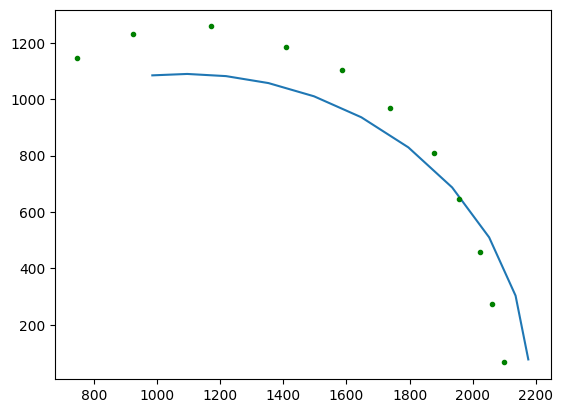

In [156]:
xx=df['Omega']
z_im=func_im(xx,*vec_popt_im[1000])
z_real=func_real(xx,*vec_popt_real[1000])
plt.plot(abs(z_real),abs(z_im))
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'g.')

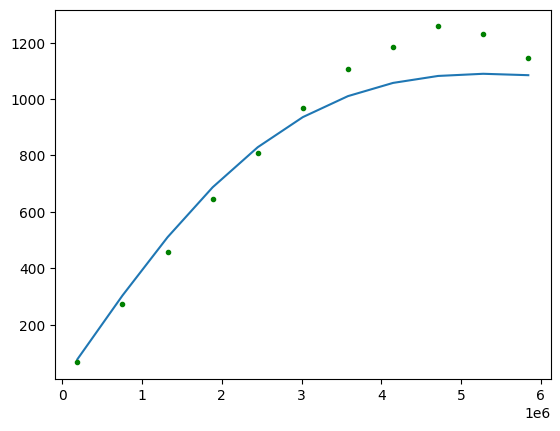

In [157]:
plt.plot(df['Omega'],np.abs(func_im(df['Omega'],*vec_popt_im[1000])))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

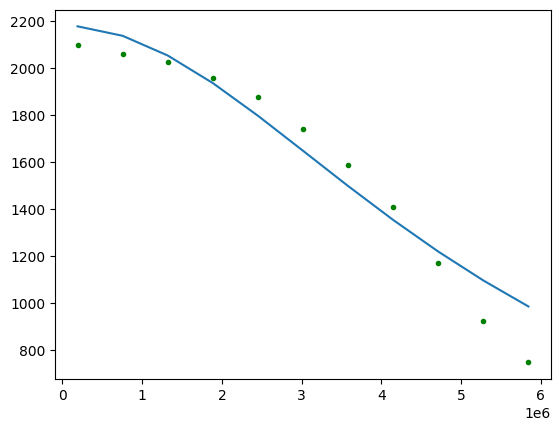

In [158]:
plt.plot(df['Omega'],np.abs(func_real(df['Omega'],*vec_popt_real[1000])))
plt.plot(df.Omega,df['Impedance_Real'],'g.')

## Loop para tentar achar a melhor aproximação para os parâmetros (saindo com a função imaginária)

In [170]:
vec_popt_real_2=np.zeros([1001,3])
vec_popt_im_2=np.zeros([1001,3])

# Saindo com a função real

vec_popt_im_2[0], vec_pcov_im = scy.curve_fit(func_real, df.Omega, df.Impedance_Real,bounds=(0,[10**6,10**2,1]),maxfev=100000)
i=0
while i<1000:
    vec_popt_real_2[i+1], vec_pcov_real=scy.curve_fit(func_im, df.Omega, df.Impedance_Imaginary,p0=vec_popt_im_2[i],bounds=(vec_popt_im_2[i],np.inf))
    vec_popt_im_2[i+1], vec_pcov_im=scy.curve_fit(func_im, df.Omega, df.Impedance_Imaginary,p0=vec_popt_real_2[i+1],bounds=(vec_popt_real_2[i+1],np.inf))
    i=i+1

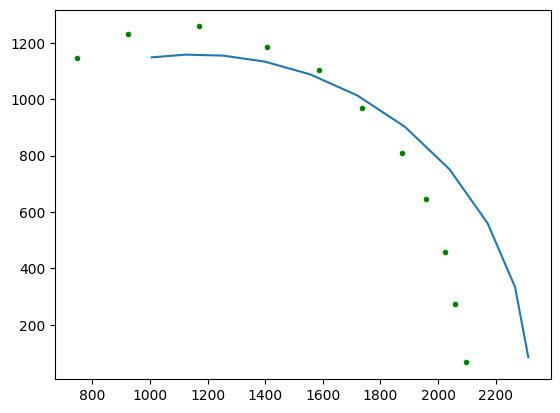

In [172]:
xx=df['Omega']
z_im=func_im(xx,*vec_popt_im_2[1000])
z_real=func_real(xx,*vec_popt_real_2[1000])
plt.plot(abs(z_real),abs(z_im))
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'g.')

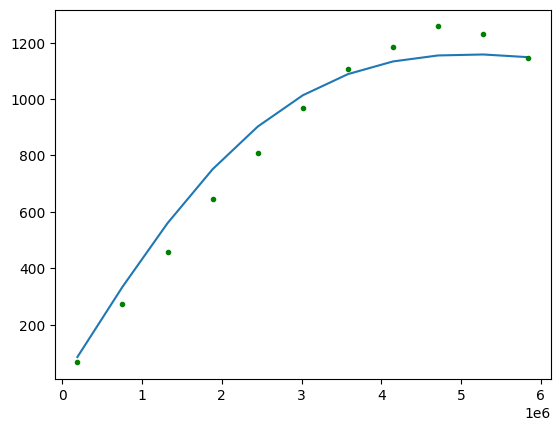

In [168]:
plt.plot(df['Omega'],np.abs(func_im(df['Omega'],*vec_popt_im_2[1000])))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

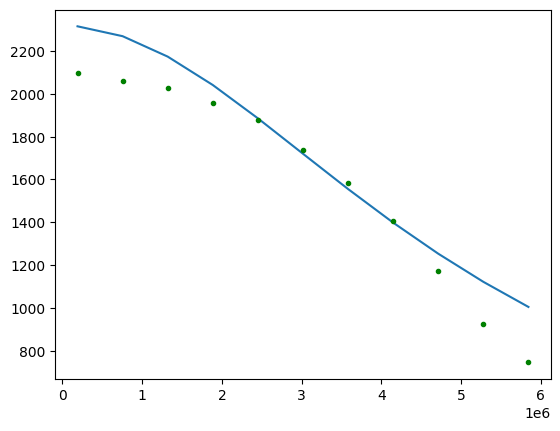

In [169]:
plt.plot(df['Omega'],np.abs(func_real(df['Omega'],*vec_popt_real_2[1000])))
plt.plot(df.Omega,df['Impedance_Real'],'g.')